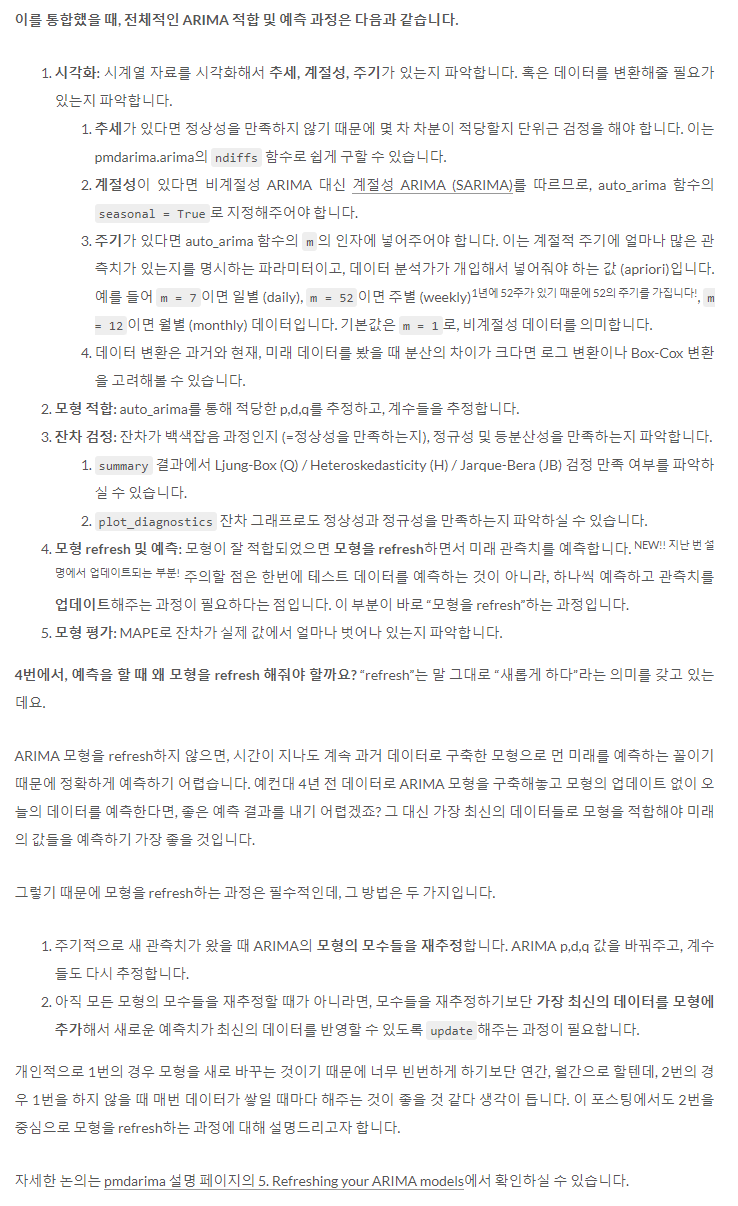

In [1]:
from IPython.display import Image
Image('images\\18.png')

In [2]:
#pip install finance-datareader
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pmdarima.arima import ndiffs
import pmdarima as pm

In [3]:
df_krx = fdr.StockListing('KRX') # 한국거래소 상장종목 전체
ticker = df_krx[df_krx.Name=='삼성전자']['Code'] # 티커
ss = fdr.DataReader(''.join(ticker.values),'2020-01-01', '2021-08-30')

<AxesSubplot: xlabel='Date'>

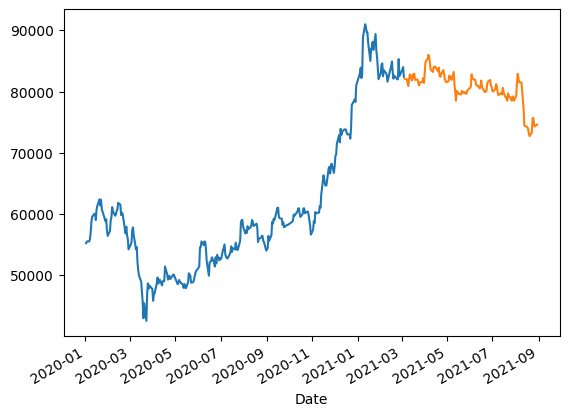

In [4]:
y_train = ss['Close'][:int(0.7*len(ss))]
y_test = ss['Close'][int(0.7*len(ss)):]
y_train.plot()
y_test.plot()

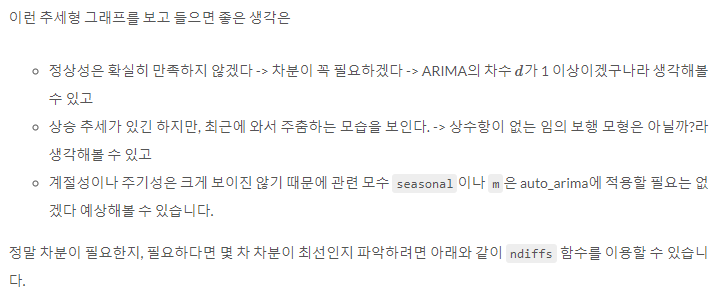

In [5]:
Image('images\\19.png')

In [6]:
kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)
print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 1


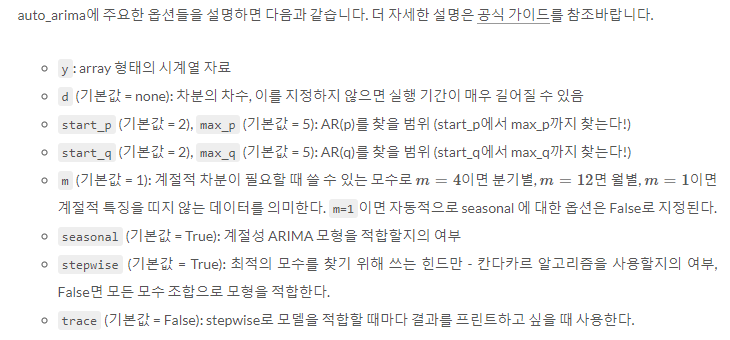

In [7]:
Image('images\\20.png')

In [8]:
model = pm.auto_arima(
    y=y_train,
    d=1,
    start_p=0,
    max_p=3,
    start_q=3,
    m=1,
    seasonal=False,
    stepwise=True,
    trace=True
)
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4940.848, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4934.821, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4936.780, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4936.799, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4934.428, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4938.798, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.102 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

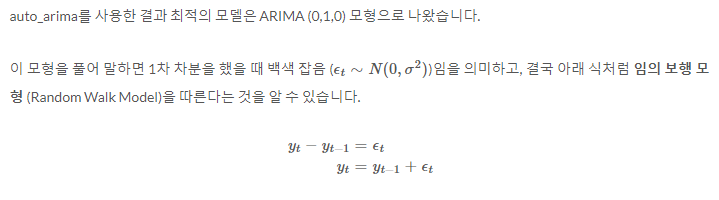

In [9]:
Image('images\\21.png')

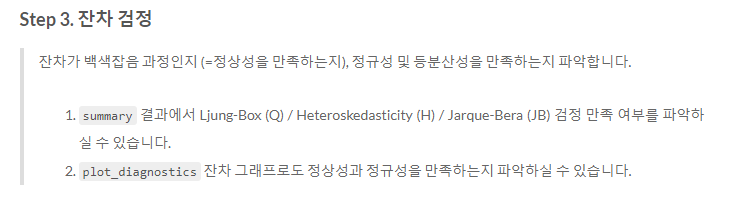

In [10]:
Image('images\\22.png')

In [11]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  289
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2466.214
Date:                Sun, 04 Dec 2022   AIC                           4934.428
Time:                        17:11:48   BIC                           4938.091
Sample:                             0   HQIC                          4935.896
                                - 289                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.599e+06   9.63e+04     16.608      0.000    1.41e+06    1.79e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                46.72
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                             0.53
Prob(H) (two-sided):                  0.06   Kurtosis:                         4.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

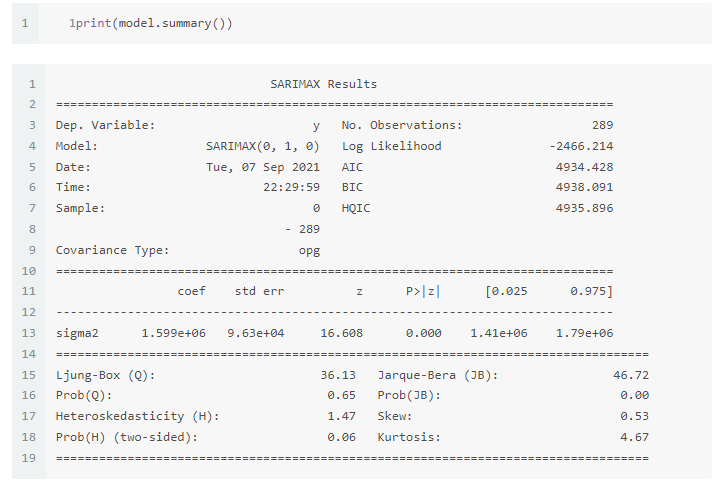

In [12]:
Image('images\\24.png')

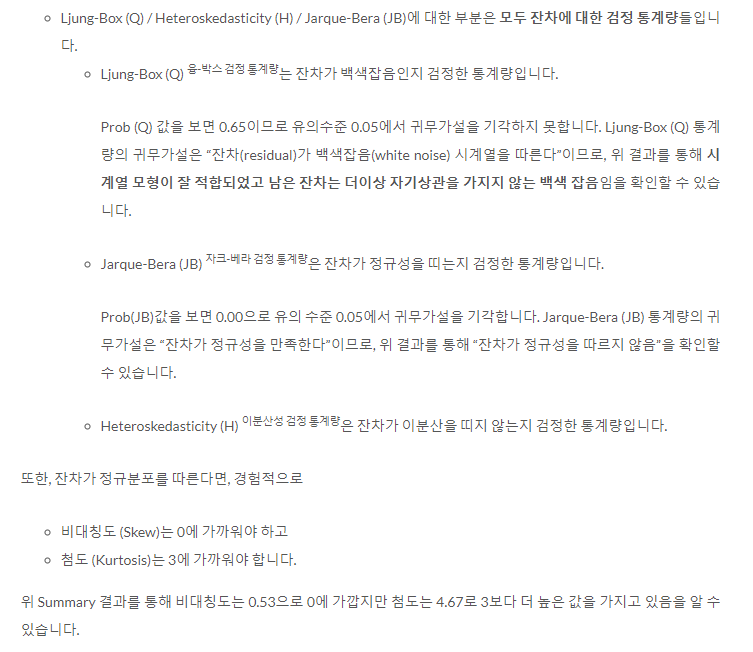

In [13]:
Image('images\\23.png')

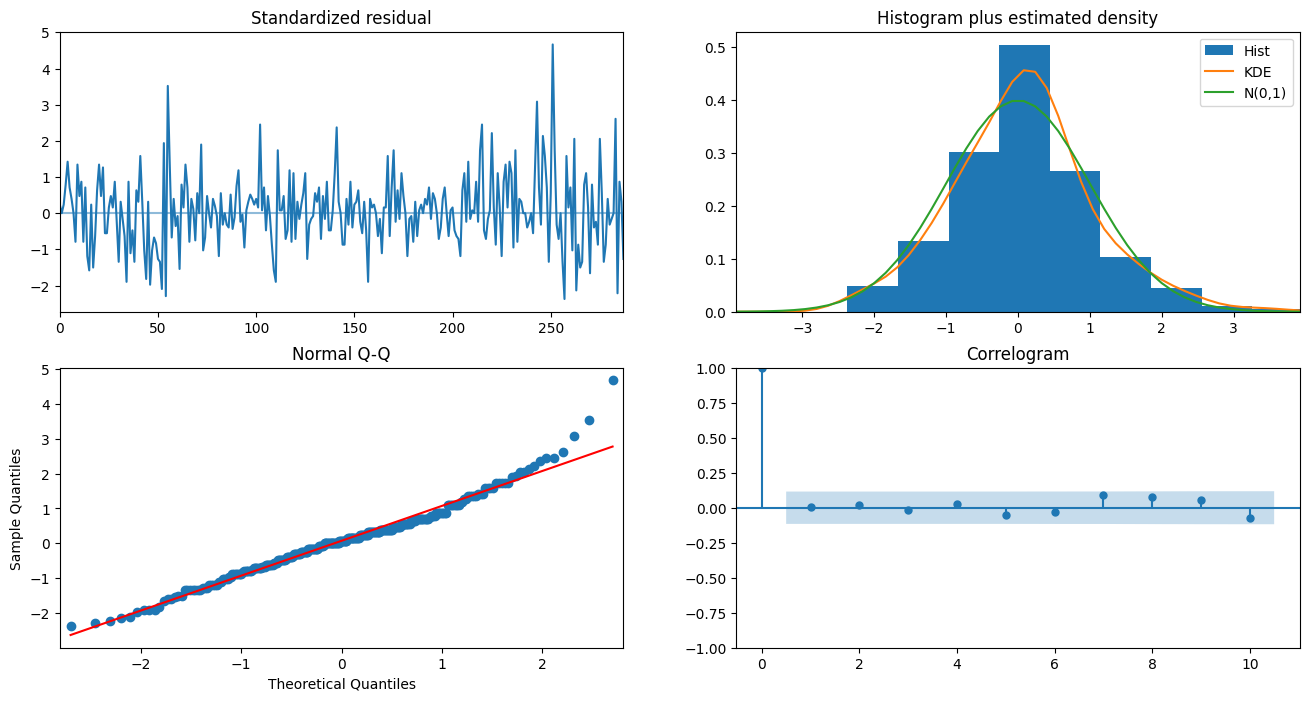

In [14]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

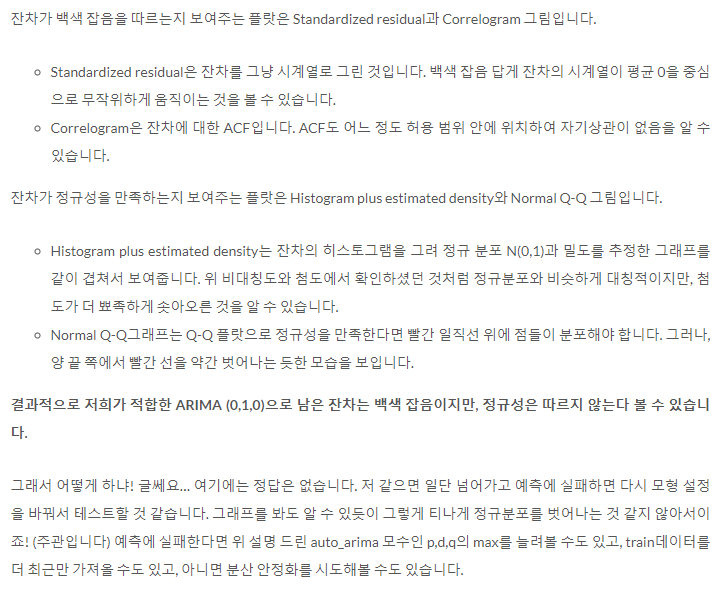

In [15]:
Image('images\\25.png')

c:\Users\SH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


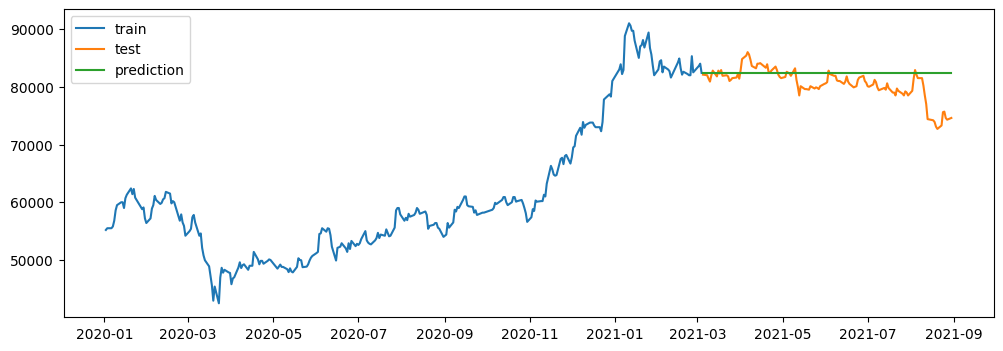

In [16]:
#step4: 모형 refresh 및 예측

#테스트 데이터 개수만큼 예측
y_predict = model.predict(n_periods=len(y_test))
y_predict = pd.DataFrame(y_predict, columns=['prediction']).reset_index(drop=True).set_index(y_test.index)

#그래프
fig, axes = plt.subplots(1,1,figsize=(12,4))
plt.plot(y_train, label='train') #훈련 데이터
plt.plot(y_test, label='test') #테스트 데이터
plt.plot(y_predict, label='prediction') #예측 데이터
plt.legend()
plt.show()

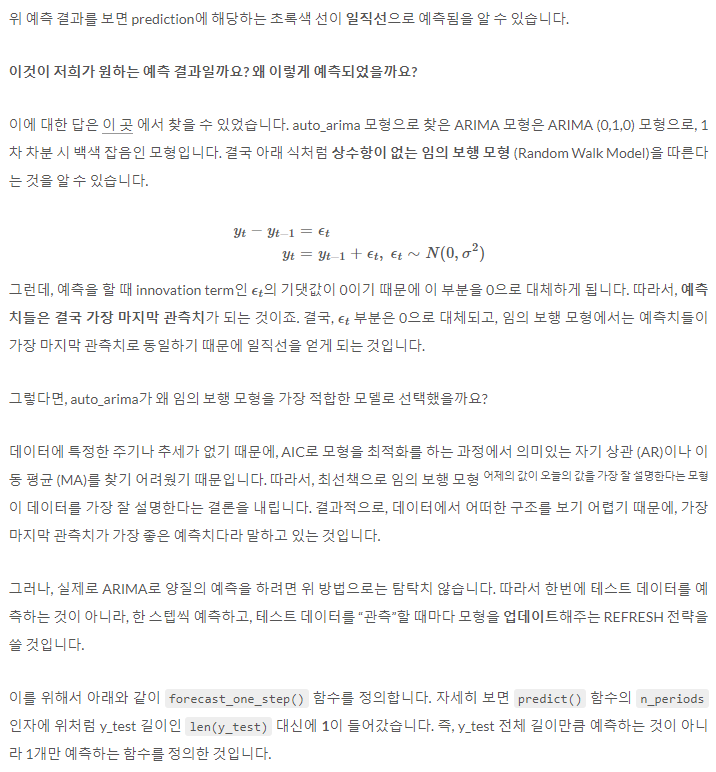

In [17]:
Image('images\\26.png')

In [18]:
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1 # 한 스텝씩!
        , return_conf_int=True)              # 신뢰구간 출력
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )

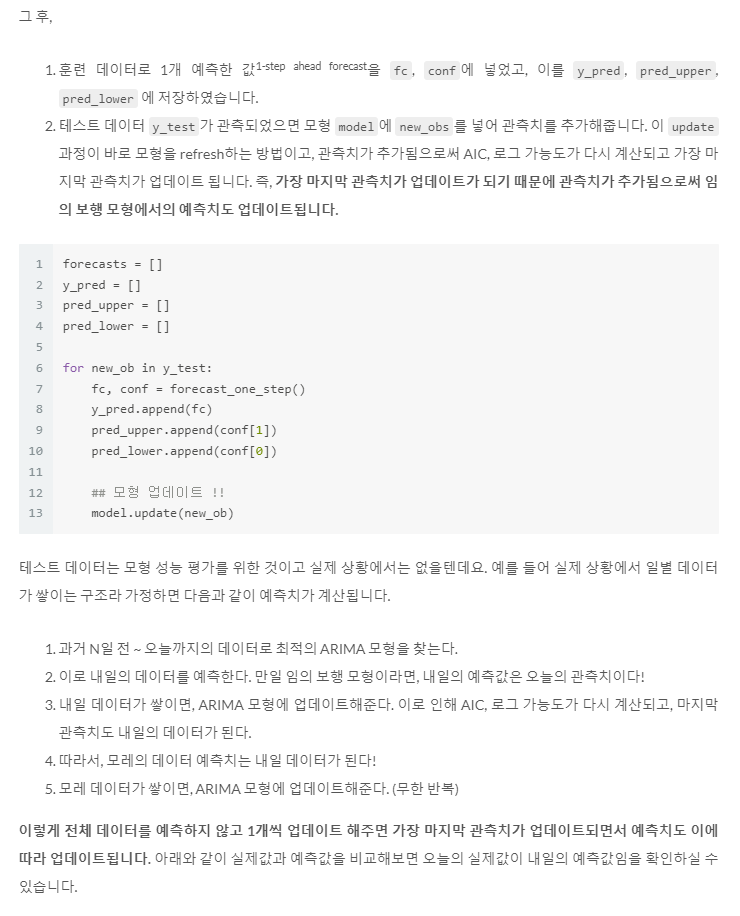

In [19]:
Image('images\\27.png')

In [20]:
forecasts = []
y_pred = []
pred_upper = []
pred_lower = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])

    ## 모형 업데이트 !!
    model.update(new_ob)

c:\Users\SH\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


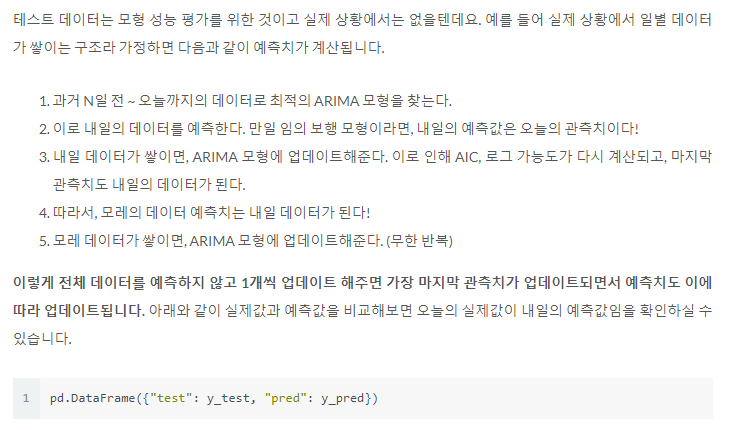

In [21]:
Image('images\\28.png')

In [22]:
pd.DataFrame({"test": y_test, "pred": y_pred})

,test,pred
Date,,
2021-03-05,82100,82400.0
2021-03-08,82000,82100.0
2021-03-09,81400,82000.0
2021-03-10,80900,81400.0
2021-03-11,82000,80900.0
...,...,...
2021-08-24,75600,73300.0
2021-08-25,75700,75600.0
2021-08-26,74600,75700.0


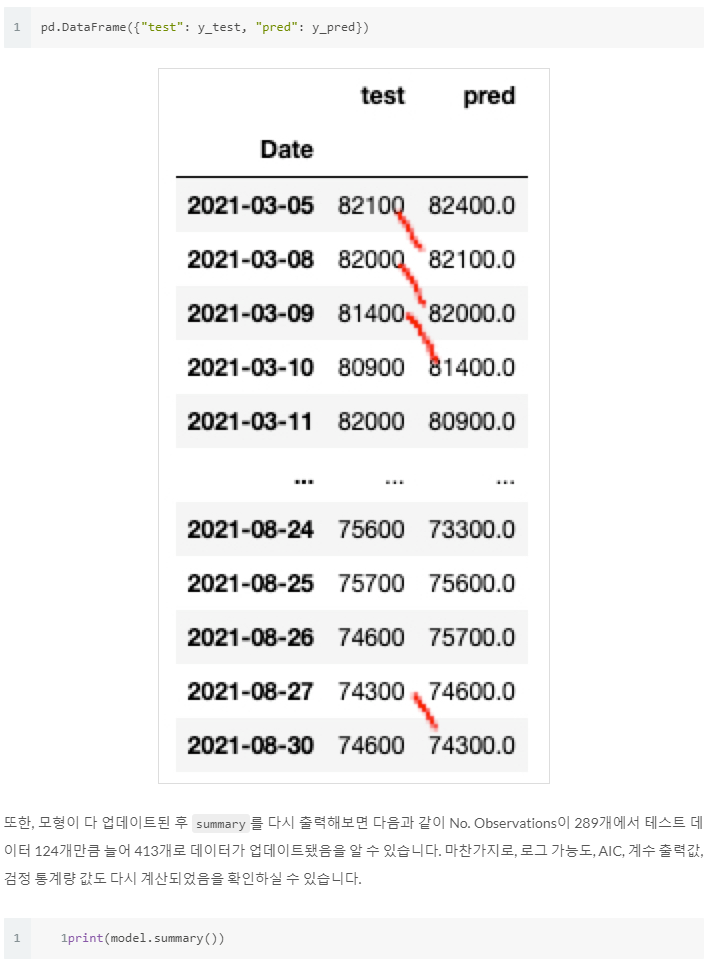

In [23]:
Image('images\\29.png')

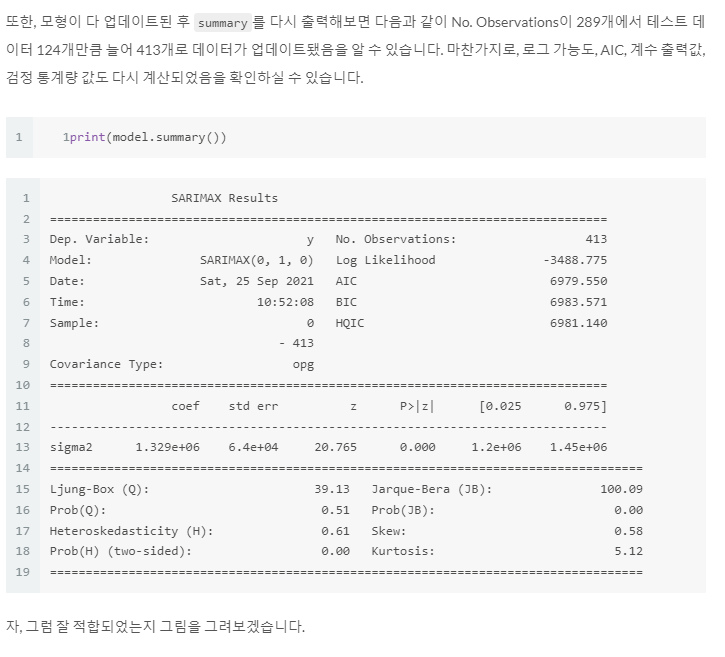

In [24]:
Image('images\\30.png')

In [25]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  413
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3488.775
Date:                Sun, 04 Dec 2022   AIC                           6979.550
Time:                        17:11:49   BIC                           6983.571
Sample:                             0   HQIC                          6981.140
                                - 413                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.329e+06    6.4e+04     20.765      0.000     1.2e+06    1.45e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):               100.09
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                             0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = go.Figure([
    # 훈련 데이터-------------------------------------------------------
    go.Scatter(x = y_train.index, y = y_train, name = "Train", mode = 'lines'
              ,line=dict(color = 'royalblue'))
    # 테스트 데이터------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_test, name = "Test", mode = 'lines'
                ,line = dict(color = 'rgba(0,0,30,0.5)'))
    # 예측값-----------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_pred, name = "Prediction", mode = 'lines'
                     ,line = dict(color = 'red', dash = 'dot', width=3))
    
    # 신뢰 구간---------------------------------------------------------
    , go.Scatter(x = y_test.index.tolist() + y_test.index[::-1].tolist() 
                ,y = pred_upper + pred_lower[::-1] ## 상위 신뢰 구간 -> 하위 신뢰 구간 역순으로
                ,fill='toself'
                ,fillcolor='rgba(0,0,30,0.1)'
                ,line=dict(color='rgba(0,0,0,0)')
                ,hoverinfo="skip"
                ,showlegend=False)
])

fig.update_layout(height=400, width=1000, title_text="ARIMA(0,1,0)모형")
fig.show()

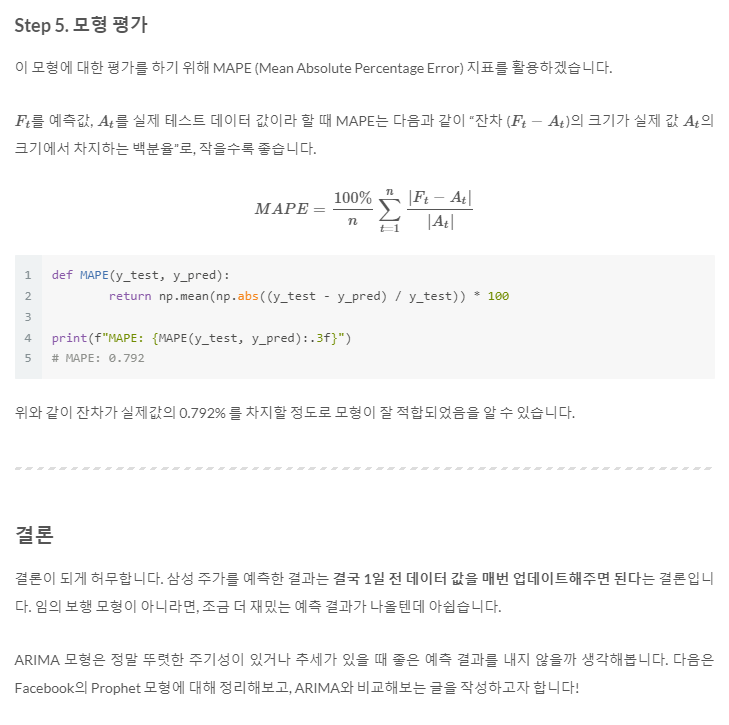

In [27]:
Image('images\\31.png')

In [28]:
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    
print(f"MAPE: {MAPE(y_test, y_pred):.3f}")
# MAPE: 0.792

MAPE: 0.792
